* Name: `dissipation-theory--Study-11.ipynb`
* Author: John A. Marohn
* Date: 2023-11-14
* Continued from: `dissipation-theory--Study-10.ipynb`
* Continued from: `2023-10-03--jam99--20230808-ringdown-NiOx-U551--Study-1.ipynb`
* Continued to: ---
* Summary: Calculate dissipation versus height over a sample with properties similar to Rachael's PM6:Y6 and compare to Marohn's analytical expression derived in the thick-sample limit.

# Preliminaries

In [76]:
import numpy as np
import matplotlib.pyplot as plt

In [77]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [78]:
from dissipationtheory.constants import epsilon0
from dissipationtheory.capacitance import Csphere

In [79]:
THIS = 'dissipation-theory--Study-11'

# Numerical computation using Lekkala and Loring's theory

Following the computation in `dissipation-theory--Study-10.ipynb`, consider a semiconductor sample with

* thickness $h_{\mathrm{s}} = 110 \: \mathrm{nm}$
* complex relative dielectric constant $\epsilon_{\mathrm{s}} = 3.4 - 0. j$
* charge density $\rho = 1 \times 10^{24} \: \mathrm{m}^{-3}$
* charge mobility $\mu = 10^{-4} \: \mathrm{cm}^2 \: \mathrm{V}^{-1} \mathrm{s}^{-1}$
  
and a cantilever with

* resonance frequency $f_{\mathrm{c}} = 75 \: \mathrm{kHz}$
* tip voltage $V_{\mathrm{ts}} = 1 \: \mathrm{V}$
* radius $r = 30 \: \mathrm{nm}$
* tip-sample separation $h = 120 \: \mathrm{nm}$

The semiconductor is backed by a metal, which we will model as a dielectric with relative dielectric constant $\epsilon_{\mathrm{d}} = 10^{6}$.   

Use Lekkala and Loring's `Model 1` to compute the perpendicular friction $\gamma_{\perp}$ versus charge density $\rho$.  Plot $\gamma_{\perp}$ *vs.* $\rho$ and then versus conductivity $\sigma = e \mu \rho$.

In [80]:
hs = ureg.Quantity(110, 'nanometer')   # measured
epsilons = complex(3.4, 0.)            # reasonable guess
rho = ureg.Quantity(1e24,'m^{-3}')     # wild guess
mu = ureg.Quantity(1e-4, 'cm^2/(s V)') # representative number

fc = ureg.Quantity(75, 'kHz')       # measured
Vts = ureg.Quantity(1, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
h = ureg.Quantity(120, 'nanometer') # measured

Print out the charge density in various units.

In [81]:
print('charge density = {:+.2e~P}'.format(rho.to('cm^{-3}')))
print('charge density = {:+.2e~P}'.format(rho.to('m^{-3}')))

charge density = +1.00e+18 1/cm³
charge density = +1.00e+24 1/m³


Compute the associated coductivity and print it out in the same units as in Rachael's draft paper.

In [82]:
sigma = (qe * mu * rho).to('S/m')

In [83]:
print('conductivity = {:+.2f~P}'.format(sigma.to('mS/m')))

conductivity = +1.60 mS/m


Now set up the simulation.

In [84]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        h.to('m').magnitude), 
    epsilon_s=epsilons,
    h_s=hs.to('m').magnitude,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=rho.to('m^{-3}').magnitude,
    epsilon_d=complex(1.0e6, 0.),
    z_r=h.to('m').magnitude)

Do a first simulation of friction versus charge density.

In [85]:
rho_= ureg.Quantity(np.logspace(start=17, stop=27, num=50), '1/m^3')
sigma_ = (qe * mu * rho_).to('1/(ohm m)')

In [86]:
%%time
result1 = {
    'rho': rho_,
    'sigma': sigma_,
    'gamma': ureg.Quantity(np.zeros_like(rho_), 'pN s/m')
}

for index, rho__ in enumerate(rho_):

        sample1_jit.rho = rho__.to('1/m^3').magnitude
        result1['gamma'][index] = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')

CPU times: user 601 ms, sys: 18.7 ms, total: 620 ms
Wall time: 770 ms


Plot the computed friction versus charge density.

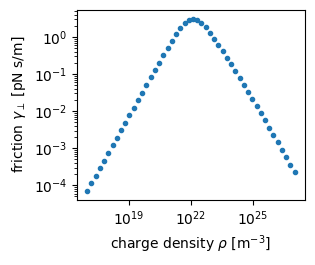

In [87]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1a.png', dpi=300)
plt.savefig(THIS + '--Fig-1a.pdf')

plt.show()

The estimated charge density of $10^{24} \: \mathrm{m}^{-3}$ is *above* the friction maximum, beyond the low-density limit.  Uh-oh.

# Analytical computation using Dwyer's model (try one)

Make an array of sample heights that is just one element long.  Do this because the function `Cphere` expects an array of heights.

In [88]:
h_ = ureg.Quantity(np.array([h.to('m').magnitude]), 'm') 
c0 = Csphere(0, height=h_, radius=r, nterm=21)
c1 = Csphere(1, height=h_, radius=r, nterm=21)

In [89]:
(c0, c1)

(array([3.70925067e-18]) <Unit('coulomb / volt')>,
 array([-2.75910095e-12]) <Unit('coulomb / meter / volt')>)

In [90]:
(c0/(epsilon0 * epsilons.real)).to('m')

Magnitude,[1.2321356886852342e-07]
Units,meter


Introduce the height to the center of the tip charge, $d = h + r$.  Compute the resistance and capacitance proportionality constants.

In [91]:
d = h + r
kR = ( (2 * np.pi * c1**2) / (c0**2/(2 * d**3) - c0*c1/(d**2) + c1**2/d)).to('m')
kC = (kR - c0/(epsilon0 * epsilons.real)).to('m')

In [92]:
(kR, kC)

(array([1.88024273e-08]) <Unit('meter')>,
 array([-1.04411142e-07]) <Unit('meter')>)

Why is $k_{\mathrm{C}}$ *negative*?  This seems unphysical.

In [93]:
Rs = 1/(sigma_ * kR)
Cs = epsilon0 * epsilons.real * kC

In [94]:
(Rs, Cs)

(array([3.31952306e+17, 2.07488512e+17, 1.29691772e+17, 8.10645155e+16,
        5.06697963e+16, 3.16714193e+16, 1.97963851e+16, 1.23738333e+16,
        7.73432875e+15, 4.83438235e+15, 3.02175579e+15, 1.88876415e+15,
        1.18058184e+15, 7.37928808e+14, 4.61246233e+14, 2.88304353e+14,
        1.80206133e+14, 1.12638779e+14, 7.04054537e+13, 4.40072944e+13,
        2.75069879e+13, 1.71933856e+13, 1.07468150e+13, 6.71735249e+12,
        4.19871605e+12, 2.62442927e+12, 1.64041314e+12, 1.02534875e+12,
        6.40899562e+11, 4.00597599e+11, 2.50395610e+11, 1.56511076e+11,
        9.78280607e+10, 6.11479373e+10, 3.82208357e+10, 2.38901318e+10,
        1.49326510e+10, 9.33373102e+09, 5.83409704e+09, 3.64663265e+09,
        2.27934667e+09, 1.42471747e+09, 8.90527054e+08, 5.56628559e+08,
        3.47923571e+08, 2.17471435e+08, 1.35931650e+08, 8.49647834e+07,
        5.31076791e+07, 3.31952306e+07]) <Unit('ohm')>,
 array([-3.14321791e-18]) <Unit('coulomb / volt')>)

Why is $C_{\mathrm{s}}$ *negative*?  Again, unphysical.  Proceed anyway.

In [95]:
result1['gamma Dwyer 1'] = ((c1**2 * Vts**2 * Rs) / (1 + (2 * np.pi * fc)**2 * Rs**2 * (c0 + Cs)**2)).to('pN s/m')

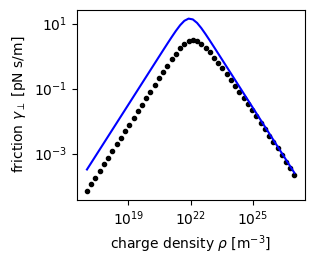

In [96]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    'k.')

plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma Dwyer 1'].to('pN s/m').magnitude,
    'b-')

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1b.png', dpi=300)
plt.savefig(THIS + '--Fig-1b.pdf')

plt.show()

In spite of $C_{\mathrm{s}}$ being negative, my ansatz for $C_{\mathrm{s}}$ and $R_{\mathrm{s}}$ predicts the correct friction in the high-density limit.  Surprisingly, the ansatz does less well in the low-density limit, the limiting case the ansatz was initially developed for. 

**Conclusion**.  Revisit my paper-and-pencil ansats for $C_{\mathrm{s}}$ and $R_{\mathrm{s}}$.  Why is $C_{\mathrm{s}}$ coming out negative?

# Analytical computation using Dwyer's model (try two)

Work out a revised paper-and-pencil theory.  The new $k_R$ is larger by a correction factor `cf` given by

In [97]:
cf2 = 2 * (epsilons.real + 1)**2 / (epsilons.real**2)

In [98]:
cf2

3.349480968858132

In [99]:
kR2 = cf2 * ( (2 * np.pi * c1**2) / (c0**2/(2 * d**3) - c0*c1/(d**2) + c1**2/d)).to('m')
kC2 = (kR2 - c0/(epsilon0 * epsilons.real)).to('m')

In [100]:
(kR2, kC2)

(array([6.29783724e-08]) <Unit('meter')>,
 array([-6.02351965e-08]) <Unit('meter')>)

In [101]:
Rs2 = 1/(sigma_ * kR2)
Cs2 = epsilon0 * epsilons.real * kC2

In [102]:
result1['gamma Dwyer 2'] = ((c1**2 * Vts**2 * Rs2) / (1 + (2 * np.pi * fc)**2 * Rs2**2 * (c0 + Cs2)**2)).to('pN s/m')

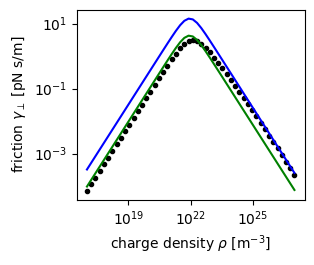

In [103]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    'k.')
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma Dwyer 1'].to('pN s/m').magnitude,
    'b-')
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma Dwyer 2'].to('pN s/m').magnitude,
    'g-')

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1c.png', dpi=300)
plt.savefig(THIS + '--Fig-1c.pdf')

plt.show()

The fit is much better, but why is $k_C$ still coming out negative?

# Analytical computation using Dwyer's model (try three)

Play with the prefactor.  Increase it until $k_C$ comes out positive.

In [104]:
kR3 = 7. * ( (2 * np.pi * c1**2) / (c0**2/(2 * d**3) - c0*c1/(d**2) + c1**2/d)).to('m')
kC3 = (kR3 - c0/(epsilon0 * epsilons.real)).to('m')

In [105]:
(kR3, kC3)

(array([1.31616991e-07]) <Unit('meter')>,
 array([8.40342217e-09]) <Unit('meter')>)

In [106]:
Rs3 = 1/(sigma_ * kR3)
Cs3 = epsilon0 * epsilons.real * kC3

result1['gamma Dwyer 3'] = ((c1**2 * Vts**2 * Rs3) / (1 + (2 * np.pi * fc)**2 * Rs3**2 * (c0 + Cs3)**2)).to('pN s/m')

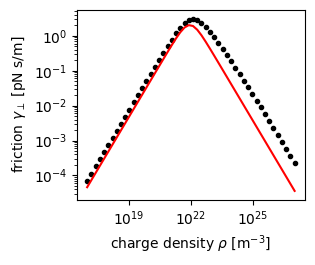

In [107]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    'k.')
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma Dwyer 3'].to('pN s/m').magnitude,
    'r-')

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1d.png', dpi=300)
plt.savefig(THIS + '--Fig-1d.pdf')

plt.show()

Playing with the prefactor of $k_R$ to make $k_C$ positive, without justification, gives a worse fit.

# Least-squares fitting (try one)

In [108]:
from lmfit import Model, Parameters

We want to fit the Lekkala simulation data, replotted below, to the Dwyer function with $k_R$ and $k_C$ as *free parameters*.

In [109]:
xfit = result1['rho'].to('1/m^3').magnitude
yfit = result1['gamma'].to('pN s/m').magnitude

Start by plotting the numerically computed friction again.

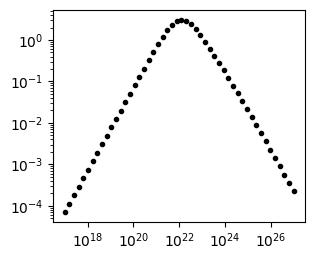

In [110]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(xfit, yfit, 'k.')
plt.show()

Create a fitting function.  The function neeeds to have unitless inputs and unitless outputs.

In [111]:
def func(rho_unitless, kR_unitless, kC_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    gamma = (c1**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (c0 + epsilon0 * epsilons.real * kC)**2)
    
    return gamma.to('pN s/m').magnitude

Try to guess reasonable starting values by plotting.

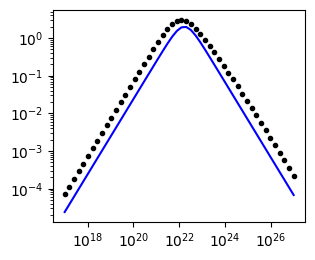

In [112]:
ycalc = func(xfit, 7e-8, 1e-8)

fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(xfit, yfit, 'k.')
plt.loglog(xfit, ycalc, 'b-')
plt.show()

Now do least-squares fitting.

* Restrict $k_R$ and $k_C$ to be positive.
* Fit with proportional error bars, or else the fit will be assuming uniform error bars and weight the largest data the most.
* Pick the error bars, arbitrarily, to be 1 percent of the data.

In [113]:
gmodel = Model(func)

pars1 = Parameters()
pars1.add('kR_unitless', value=7e-8, min=0)
pars1.add('kC_unitless', value=1e-8, min=0)

yerr = 0.01 * yfit
result1 = gmodel.fit(yfit, rho_unitless=xfit, params=pars1, weights=1/yerr)

In [114]:
result1

In [115]:
def plotfit(xfit, yfit, ycalc, yerr, figname):

    fig, axs = plt.subplots(
        figsize=(3.25,4.00),
        nrows=2,
        sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    
    dy = 100 * (yfit - ycalc)/yfit
    opts = dict(marker='o', mfc='w', ms=4, capsize=3, linestyle='none')
    
    axs[0].errorbar(xfit, dy, yerr=yerr, **opts, color='tab:blue')
    axs[0].set_ylabel('resid. [%]')
    
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].errorbar(xfit, yfit, yerr=yerr, **opts, color='tab:blue')
    axs[1].plot(xfit, ycalc, 'k-')
    
    plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
    plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
    
    fig.align_ylabels()
    plt.tight_layout()
    
    plt.savefig(THIS + '--' + figname, dpi=300)
    plt.savefig(THIS + '--' + figname + '.pdf')
    
    plt.show()

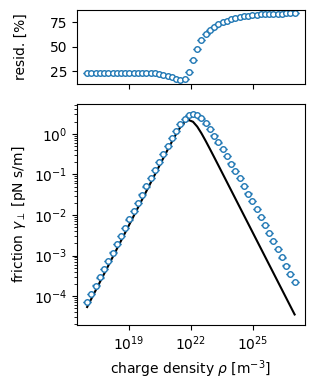

In [116]:
ycalc =  result1.best_fit
plotfit(xfit, yfit, ycalc, yerr, 'Fig-2a')

The fit is OK at low density but not OK at high density.  This is puzzling.  **Lift the restriction that $k_R$ and $k_C$ are positive**.  That is, allow the parameters to be negative.

In [117]:
pars2 = Parameters()
pars2.add('kR_unitless', value=1e-8)
pars2.add('kC_unitless', value=1e-8)

In [118]:
result2 = gmodel.fit(yfit, rho_unitless=xfit, params=pars2, weights=1/yerr)
result2

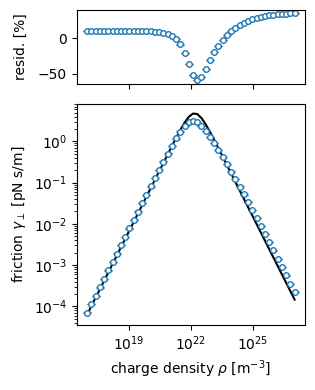

In [119]:
ycalc =  result2.best_fit
plotfit(xfit, yfit, ycalc, yerr, 'Fig-2b')

The fit is improved, but now $k_C$ is negative, which seems unphysical.  Compute the various capacitance terms:

In [120]:
Cs = epsilon0 * epsilons.real * ureg.Quantity(result2.best_values['kC_unitless'],'m')
(c0[0], Cs, c0[0] + Cs)

(3.70925067148073e-18 <Unit('coulomb / volt')>,
 -2.028543768803343e-18 <Unit('coulomb / volt')>,
 1.6807069026773872e-18 <Unit('coulomb / volt')>)

The negative $k_C$ is telling me that the estimated tip capacitance is too large.  Why would that be?

# Least-squares fitting (try two)

In [121]:
from dissipationtheory.capacitance import CsphereOverSemi

Compute the tip-sample capacitance by modeling the sample as a semi-infinite semiconductor, not a metal, as was implicitly assumed above.

In [122]:
c0s = CsphereOverSemi(0, height=h_, radius=r, epsilon=epsilons.real, nterm=21)
c1s = CsphereOverSemi(1, height=h_, radius=r, epsilon=epsilons.real, nterm=21)

The capacitance is about five percent smaller.

In [123]:
(c0, c0s)

(array([3.70925067e-18]) <Unit('coulomb / volt')>,
 array([3.53063657e-18]) <Unit('coulomb / volt')>)

The capacitance first derivative, however, is nearly a factor of two smaller.

In [124]:
(c1, c1s)

(array([-2.75910095e-12]) <Unit('coulomb / meter / volt')>,
 array([-1.36099415e-12]) <Unit('coulomb / meter / volt')>)

Redefine the fitting function to incorporate the new capacitance and derivatives.

In [125]:
def funcs(rho_unitless, kR_unitless, kC_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    gamma = (c1s**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (c0s + epsilon0 * epsilons.real * kC)**2)
    
    return gamma.to('pN s/m').magnitude

Redo the fit. Restrict $k_C$ to be positive.

In [126]:
gmodels = Model(funcs)

pars3 = Parameters()
pars3.add('kR_unitless', value=1e-8)
pars3.add('kC_unitless', value=1e-8, min=0)

result3 = gmodels.fit(yfit, rho_unitless=xfit, params=pars3, weights=1/yerr)

In [127]:
result3

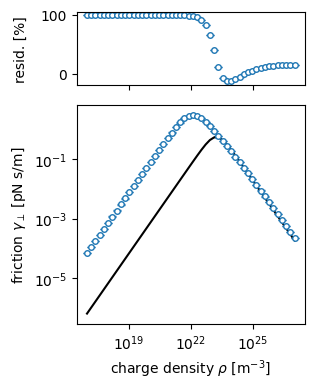

In [128]:
plotfit(xfit, yfit, result3.best_fit, yerr, 'Fig-2c')

With $k_C$ constrained to be positive, the first is now much worse. Compare the various capacitance terms.

In [129]:
Cs = epsilon0 * epsilons.real * ureg.Quantity(result3.best_values['kC_unitless'],'m')
(c0[0], c0s[0], Cs, c0s[0] + Cs)

(3.70925067148073e-18 <Unit('coulomb / volt')>,
 3.530636565678586e-18 <Unit('coulomb / volt')>,
 1.2894369169964577e-23 <Unit('coulomb / volt')>,
 3.530649460047756e-18 <Unit('coulomb / volt')>)

Fit the low-density region, with $k_C$ unconstrained.

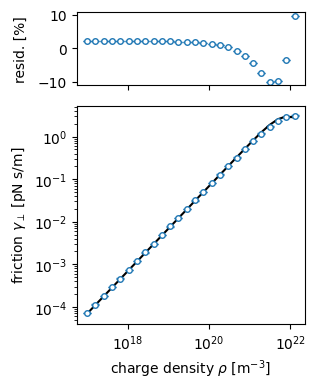

In [130]:
xmax = xfit[yfit.argmax()]

result4 = gmodels.fit(
    yfit[xfit <= xmax], 
    rho_unitless=xfit[xfit <= xmax], 
    params=pars2, 
    weights=1/yerr[xfit <= xmax])

plotfit(
    xfit[xfit <= xmax],
    yfit[xfit <= xmax],
    result4.best_fit,
    yerr[xfit <= xmax], 'Fig-2d')

In [131]:
result4

Fit the high-density region, with $k_C$ unconstrained.

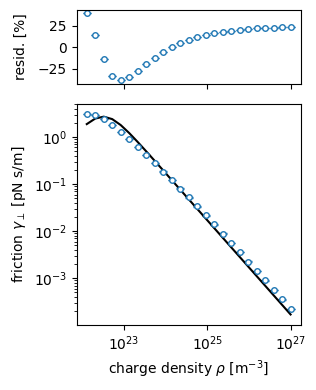

In [132]:
xmax = xfit[yfit.argmax()]

result5 = gmodels.fit(
    yfit[xfit >= xmax], 
    rho_unitless=xfit[xfit >= xmax], 
    params=pars2, 
    weights=1/yerr[xfit >= xmax])

plotfit(
    xfit[xfit >= xmax],
    yfit[xfit >= xmax],
    result5.best_fit,
    yerr[xfit >= xmax], 'Fig-2e')

In [133]:
result5

Allow the capacitance to be negative.

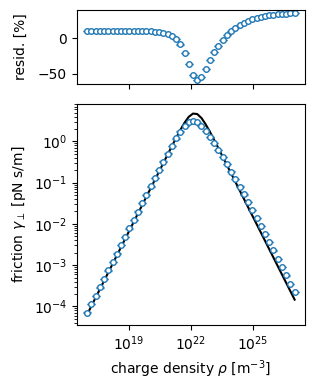

In [134]:
gmodels = Model(funcs)
result6 = gmodels.fit(yfit, rho_unitless=xfit, params=pars2, weights=1/yerr)
plotfit(xfit, yfit, result6.best_fit, yerr, 'Fig-2f')

In [135]:
result6

So, this new model also fits well only if the sample capacitance is allowed to be negative.

# Least-squares fitting (try three)

Derive a new model with a sample surface capacitance in series with the tip capacitance.  For now, compute capacitance using the semi-infinite semiconductor model.  In this new model, $\delta = C_0/C_{\mathrm{surf}}$, with $C_0$ the tip capacitance and $C_{\mathrm{surf}}$ the surface capacitance in series with $C_0$.

In [136]:
def func2(rho_unitless, kR_unitless, kC_unitless, delta_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    corr = 1/(1 + delta_unitless)
    gamma = (corr**2 * c1s**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (corr * c0 + epsilon0 * epsilons.real * kC)**2)
    
    return gamma.to('pN s/m').magnitude

Constrain $k_R$, $k_C$, and $\delta = C_0/C_{\mathrm{surf}}$ to all be positive.

In [137]:
gmodel2 = Model(func2)

pars7 = Parameters() 
pars7.add('kR_unitless', value=1e-8, min=0)
pars7.add('kC_unitless', value=1e-8, min=0)
pars7.add('delta_unitless', value=0.1, min=0)

result7 = gmodel2.fit(yfit, rho_unitless=xfit, params=pars7, weights=1/yerr)

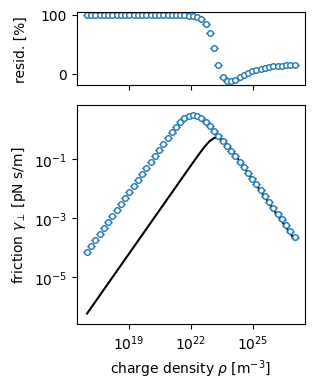

In [138]:
plotfit(xfit, yfit, result7.best_fit, yerr, 'Fig-3a')
result7

This fit has the same problems as above.  If we constrain the parameters to be positive, the fit is poor.

# Least-squares fitting (try four)

Derive another model with a sample surface capacitance in series with the sample resistance.  For now, compute capacitance using the semi-infinite semiconductor model.  In this new model, $\delta = (C_0 + C_{\mathrm{s}})/C_{\mathrm{surf}}$, with $C_0$ the tip capacitance, $C_{\mathrm{s}}$ the sample capactiance, and $C_{\mathrm{surf}}$ the surface capacitance in series with $R_{\mathrm{s}}$.

In [139]:
def func3(rho_unitless, kR_unitless, kC_unitless, delta_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    corr = 1/(1 + delta_unitless)
    gamma = (corr**2 * c1s**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * corr**2 * (c0 + epsilon0 * epsilons.real * kC)**2)
    
    return gamma.to('pN s/m').magnitude

Constrain $k_R$, $k_C$, and $\delta = C_0/C_{\mathrm{surf}}$ to all be positive.

In [140]:
gmodel3 = Model(func3)

pars9 = Parameters() 
pars9.add('kR_unitless', value=1e-8, min=0)
pars9.add('kC_unitless', value=1e-8, min=0)
pars9.add('delta_unitless', value=1, min=0)

result9 = gmodel3.fit(yfit, rho_unitless=xfit, params=pars9, weights=1/yerr)

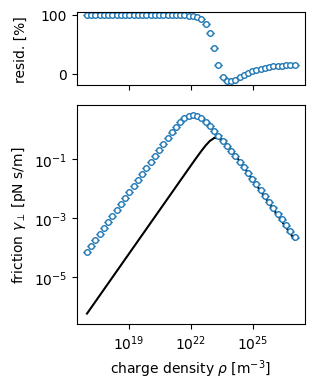

In [141]:
plotfit(xfit, yfit, result9.best_fit, yerr, 'Fig-4a')
result9

So adding $C_{\mathrm{surf}}$ in parallel with $R_{\mathrm{s}}$ does not give an improved fit either.  

# Least-squares fitting (try five)

OK, guess an empirial function.  Here the capacitance in the denominator of the Dwyer-like expression is $C = \epsilon_0 k_C$ with $k_C$ an empirial constant that has units of length.

In [148]:
def func4(rho_unitless, kR_unitless, kC_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    gamma = (c1s**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (epsilon0 * kC)**2)
    
    return gamma.to('pN s/m').magnitude

In [149]:
gmodel4 = Model(func4)

pars10 = Parameters() 
pars10.add('kR_unitless', value=1e-8, min=0)
pars10.add('kC_unitless', value=1e-8, min=0)

result10 = gmodel4.fit(yfit, rho_unitless=xfit, params=pars10, weights=1/yerr)

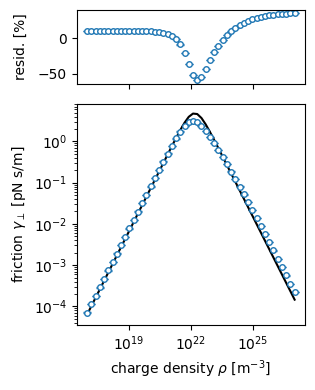

In [150]:
plotfit(xfit, yfit, result10.best_fit, yerr, 'Fig-5a')
result10

Compare the 
* tip capacitance assuming a metallic substrate,
* tip capacitance assuming a semiconductor substrate, and
* the empirically-determined capacitance $C$ obtained from the above fit.  

In [151]:
C = epsilon0 * ureg.Quantity(result10.best_values['kC_unitless'],'m')
(c0[0], c0s[0], C)

(3.70925067148073e-18 <Unit('coulomb / volt')>,
 3.530636565678586e-18 <Unit('coulomb / volt')>,
 4.089498175588166e-19 <Unit('coulomb / volt')>)

The fit is quite nice, but the empirically-determined capacitance $C$ is *less that* the tip capacitance $c_0$.  This finding is at odds with the Dwyer treatment, which predicts that $C = c_0 + C_{\mathrm{s}}$ with $c_0$ the tip capacitance and $C_{\mathrm{s}}$ the sample capacitance, requiring that $C > c_0$.

In [152]:
d = h + r
prefactor = (epsilons.real + 1)**2/epsilons.real**2
kR_calc1 = ((4 * np.pi * prefactor * c1**2) / (c0**2/(2 * d**3) - c0*c1/(d**2) + c1**2/d)).to('m')
kR_calc2 = ((4 * np.pi * prefactor * c1s**2) / (c0s**2/(2 * d**3) - c0s*c1s/(d**2) + c1s**2/d)).to('m')
kR_fit = ureg.Quantity(result10.best_values['kC_unitless'],'m')

In [153]:
(kR_calc1[0].to('nm'),
 kR_calc2[0].to('nm'), 
 kR_fit.to('nm'))

(62.978372381196884 <Unit('nanometer')>,
 18.8081732442082 <Unit('nanometer')>,
 46.18716320514692 <Unit('nanometer')>)

So the best-fit value of $k_R^{\mathrm{best \: fit}} = 46.2$ nm is larger than $k_R^{\mathrm{calc \: 2}} = 18.8$ nm, calculated by treating the sample as a semi-infinite semiconductor, but smaller than $k_R^{\mathrm{calc \: 1}} = 63.0$ nm, calculated by treating the sample as a metal.